In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
import os
from itertools import product
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [2]:
datafolder ='data/'
oil= pd.read_csv(os.path.join(datafolder,'oil.csv'))
holidays_events=pd.read_csv(os.path.join(datafolder,'holidays_events.csv'))
stores= pd.read_csv(os.path.join(datafolder,'stores.csv'))
train= pd.read_csv(os.path.join(datafolder,'train.csv'))
test= pd.read_csv(os.path.join(datafolder,'test.csv'))
transactions= pd.read_csv(os.path.join(datafolder,'transactions.csv'))

In [3]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

# moving average
df_oil = pd.read_csv(datafolder + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)




In [4]:
calendar['dofw'] = calendar.index.dayofweek

In [5]:
df_events = pd.read_csv(datafolder + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_events['date'] = df_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction

df_events = df_events.set_index('date').sort_index()
df_events = df_events[df_events.locale == 'National'] 
df_events = df_events.groupby(df_events.index).first() # Keep one event only

In [6]:
df_events = pd.read_csv(datafolder + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_events['date'] = df_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction

df_events = df_events.set_index('date').sort_index()
df_events = df_events[df_events.locale == 'National'] 
df_events = df_events.groupby(df_events.index).first() # Keep one event only

In [10]:
calendar['wd'] = True

calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_events, how='left', left_index=True, right_index=True)
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [7]:
df_train = pd.read_csv(datafolder + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)
df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test = pd.read_csv(datafolder + 'test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)
df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [8]:
end_date='2017-08-15'
start_date='2017-04-01'

In [11]:
y = df_train.unstack(['store_nbr', 'family']).loc[start_date:end_date]

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

# Extentions

X['oil']  = calendar.loc[start_date:end_date]['ma_oil'].values
X['dofw'] = calendar.loc[start_date:end_date]['dofw'].values
X['wd']   = calendar.loc[start_date:end_date]['wd'].values
X['type'] = calendar.loc[start_date:end_date]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True) # try alpha,0.1 ,0.3 ,0.6 and 0.9
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

/Users/tijsvandervelden/opt/anaconda3/envs/TS/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [28]:
X

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,type_Transfer
date,,,,,,,,,,,,,,,,,,,
2017-04-01,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,48.570000,False,0,0,0,0,1,0,0,0,0,0
2017-04-02,2.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,48.570000,False,0,0,0,0,0,1,0,0,0,0
2017-04-03,3.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.034286,True,0,0,0,0,0,0,0,0,0,0
2017-04-04,4.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,49.561429,True,1,0,0,0,0,0,0,0,0,0
2017-04-05,5.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,50.150000,True,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,133.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,49.140000,False,0,0,0,1,0,0,0,0,0,1
2017-08-12,134.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,49.140000,False,0,0,0,0,1,0,0,0,0,0
2017-08-13,135.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.140000,False,0,0,0,0,0,1,0,0,0,0


In [12]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

<AxesSubplot:xlabel='date'>

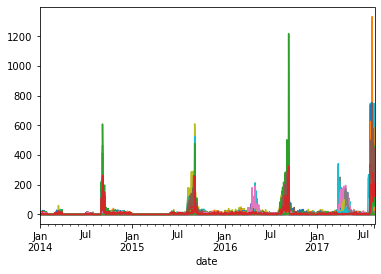

In [13]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [15]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble     import RandomForestRegressor

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [16]:
model = CustomRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [17]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

In [18]:
end_test='2017-08-31'
start_test='2017-08-16'
X_test = dp.out_of_sample(steps=16)

# Extentions
X_test['oil']  = calendar.loc[start_test:end_test]['ma_oil'].values
X_test['dofw'] = calendar.loc[start_test:end_test]['dofw'].values
X_test['wd']   = calendar.loc[start_test:end_test]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. 

In [23]:
sales_pred

sales
           store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     4.309557
                     BABY CARE                      0.000000
                     BEAUTY                         3.998301
                     BEVERAGES                   2417.365382
                     BOOKS                          0.482959
...                                                      ...
2017-08-31 9         POULTRY                      336.982537
                     PREPARED FOODS                93.747146
                     PRODUCE                     1267.738442
                     SCHOOL AND OFFICE SUPPLIES   142.120000
                     SEAFOOD                       14.324872

[28512 rows x 1 columns]

In [ ]:
sales_pred.values

In [19]:
My_submission = pd.read_csv(datafolder + 'sample_submission.csv', index_col='id')
My_submission.sales = sales_pred.values
My_submission.to_csv('submission.csv', index=True)

In [20]:
My_submission

,sales
id,
3000888,4.309557
3000889,0.000000
3000890,3.998301
3000891,2417.365382
3000892,0.482959
...,...
3029395,336.982537
3029396,93.747146
3029397,1267.738442
